In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import files
files.upload()  # 'kaggle.json' 파일 업로드

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d misrakahmed/vegetable-image-dataset

# 압축 해제
!unzip vegetable-image-dataset.zip -d vegetable-image-dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetable-image-dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: vegetable-image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = "./vegetable-image-dataset/Vegetable Images/"
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,  # 정규화
#     rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
#     shear_range=0.2, zoom_range=0.2, horizontal_flip=True
# )

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# 학습 데이터 로드
train_generator = train_datagen.flow_from_directory(
    directory=f"{data_path}/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # One-hot encoding
    shuffle=True
)

# 검증 데이터 로드
val_generator = val_test_datagen.flow_from_directory(
    directory=f"{data_path}/validation",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # 순서 유지
)

# 테스트 데이터 로드
test_generator = val_test_datagen.flow_from_directory(
    directory=f"{data_path}/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


### ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# 사전 훈련된 EfficientNetB0 모델 로드 (ImageNet 가중치 사용)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False  # 기본 가중치는 고정

print(type(base_model.output))
# 커스텀 분류기
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(15, activation="softmax")(x)  # 클래스 개수에 맞춰 조정

# 모델 정의
model = Model(inputs=base_model.input, outputs=x)

for layer in model.layers:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


checkpoint = ModelCheckpoint(
    "best_model.h5",  # 저장할 모델 파일명
    monitor="val_loss",  # 기준 지표 (Validation Loss가 최소일 때 저장)
    save_best_only=True,  # 가장 좋은 성능의 모델만 저장
    mode="min",  # Loss는 최소값이 최적이므로 "min" 설정
    verbose=1  # 저장될 때마다 메시지 출력
)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint]  # ModelCheckpoint 추가
)

# 모델 평가
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7931 - loss: 0.7778
Epoch 1: val_loss improved from inf to 12.63164, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 398ms/step - accuracy: 0.7933 - loss: 0.7771 - val_accuracy: 0.0667 - val_loss: 12.6316
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9547 - loss: 0.1588
Epoch 2: val_loss improved from 12.63164 to 3.45535, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 315ms/step - accuracy: 0.9548 - loss: 0.1588 - val_accuracy: 0.4170 - val_loss: 3.4554
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9764 - loss: 0.0812
Epoch 3: val_loss improved from 3.45535 to 0.47107, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 321ms/step - accuracy: 0.9764 - loss: 0.0812 - val_accuracy: 0.8697 - val_loss: 0.4711
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9700 - loss: 0.1010
Epoch 4: val_loss improved from 0.47107 to 0.33390, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 317ms/step - accuracy: 0.9700 - loss: 0.1010 - val_accuracy: 0.9103 - val_loss: 0.3339
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9793 - loss: 0.0711
Epoch 5: val_loss did not improve from 0.33390
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 307ms/step - accuracy: 0.9793 - loss: 0.0710 - val_accuracy: 0.9097 - val_loss: 0.4974
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9774 - loss: 0.0776
Epoch 6: val_loss did not improve from 0.33390
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 305ms/step - accuracy: 0.9774 - loss: 0.0776 - val_accuracy: 0.7713 - val_loss: 1.3936
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9821 - loss: 0.0610
Epoch 7: val_loss did not improve from 0.33390
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 305ms/step - accuracy: 0.9821 - loss: 0.0610 - val_accuracy: 0.8297 - val_loss: 0.9982
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9867 - loss: 0.0495
Epoch 8: val_loss did n

469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 319ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9440 - val_loss: 0.2345
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9864 - loss: 0.0451
Epoch 10: val_loss improved from 0.23453 to 0.20526, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 319ms/step - accuracy: 0.9864 - loss: 0.0451 - val_accuracy: 0.9507 - val_loss: 0.2053
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9729 - loss: 0.1105
Test Loss: 0.309128999710083
Test Accuracy: 0.9416666626930237


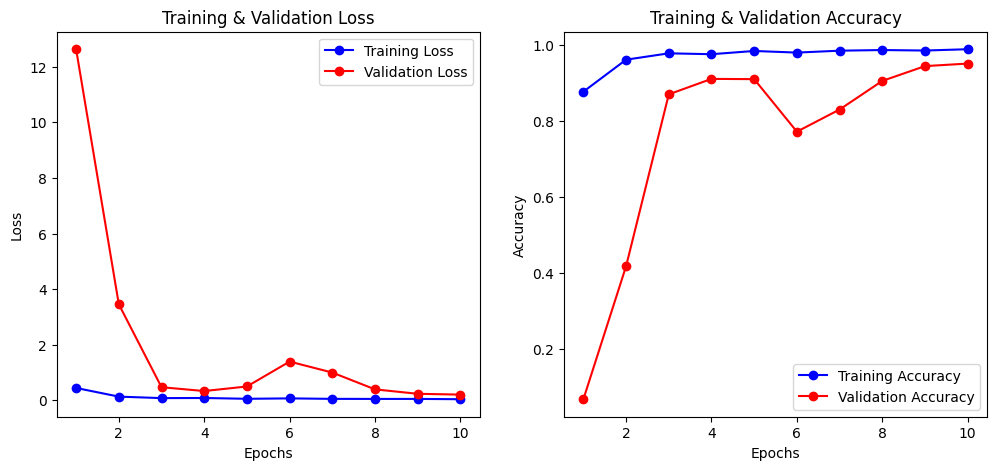

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서 저장된 Loss & Accuracy 값 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)  # Epoch 수

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


### ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# ResNet18 불러오기 (사전 훈련된 가중치 사용)
model = models.resnet18(pretrained=True)

# 마지막 FC 레이어 변경 (15개 클래스 기준)
num_classes = 15  # 분류할 클래스 개수
model.fc = nn.Linear(model.fc.in_features, num_classes)

# GPU 사용 가능하면 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("ResNet18 모델 준비 완료!")
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


✅ ResNet18 모델 준비 완료!
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [ ]:
# 손실 함수 (Categorical CrossEntropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (Adam 사용)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 감소 (ReduceLROnPlateau) 적용
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)


In [ ]:
# 학습 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_accuracy = 0.0  # 최고 검증 정확도 저장
    model.train()  # 모델을 학습 모드로 변경

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # 기존 그래디언트 초기화
            outputs = model(images)  # 모델 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # 검증 (Validation)
        model.eval()  # 평가 모드
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # 검증에서는 그래디언트 계산 X
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        # 학습 및 검증 결과 출력
        train_acc = 100 * correct / total
        val_acc = 100 * correct_val / total_val
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Acc: {val_acc:.2f}%")

        # 스케줄러 업데이트 (학습률 감소)
        scheduler.step(val_loss)

        # 최고 성능 모델 저장
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), "best_resnet18.pth")  # 모델 저장
            print("🎯 Model Saved!")

    print("학습 완료!")


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# transform 정의 (ResNet18에 맞는 형식으로 변환)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 조정
    transforms.ToTensor(),  # (H, W, C) → (C, H, W) 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# ImageFolder를 사용하여 데이터셋 로드 (train_generator 대체)
train_dataset = datasets.ImageFolder(root="/content/vegetable-image-dataset/Vegetable-Images/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/content/vegetable-image-dataset/Vegetable-Images/validation", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/vegetable-image-dataset/Vegetable-Images/test", transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(" transform이 적용된 DataLoader 생성 완료!")


✅ transform이 적용된 DataLoader 생성 완료!


In [ ]:
num_epochs = 10  # 학습 횟수 설정

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch [1/10] - Train Loss: 0.1908, Train Acc: 95.00%
Validation Loss: 0.0191, Validation Acc: 99.60%
🎯 Model Saved!
Epoch [2/10] - Train Loss: 0.0543, Train Acc: 98.42%
Validation Loss: 0.1616, Validation Acc: 94.87%
Epoch [3/10] - Train Loss: 0.0201, Train Acc: 99.40%
Validation Loss: 0.0715, Validation Acc: 97.80%
Epoch [4/10] - Train Loss: 0.0173, Train Acc: 99.49%
Validation Loss: 0.0132, Validation Acc: 99.70%
🎯 Model Saved!
Epoch [5/10] - Train Loss: 0.0124, Train Acc: 99.65%
Validation Loss: 0.0099, Validation Acc: 99.77%
🎯 Model Saved!
Epoch [6/10] - Train Loss: 0.0054, Train Acc: 99.82%
Validation Loss: 0.0130, Validation Acc: 99.67%
Epoch [7/10] - Train Loss: 0.0107, Train Acc: 99.66%
Validation Loss: 0.0104, Validation Acc: 99.70%
Epoch [8/10] - Train Loss: 0.0165, Train Acc: 99.53%
Validation Loss: 0.0289, Validation Acc: 99.13%
Epoch [9/10] - Train Loss: 0.0044, Train Acc: 99.87%
Validation Loss: 0.0065, Validation Acc: 99.87%
🎯 Model Saved!
Epoch [10/10] - Train Loss: 0.0

In [ ]:
# 저장된 최고 모델 로드
model.load_state_dict(torch.load("best_resnet18.pth"))
model.to(device)
model.eval()

# 테스트 데이터 평가
test_correct, test_total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
print(f"최종 테스트 정확도: {test_acc:.2f}%")


🎯 최종 테스트 정확도: 99.70%
